In [2]:
from hnn_core import simulate_dipole, calcium_model, MPIBackend, read_params, jones_2009_model
import os.path as op
import hnn_core
from hnn_core.network import pick_connection
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import add_supra_beta_drives, rescale_pyr_morph
sns.set()
sns.set_style("whitegrid")


In [3]:
def law_2021_model():
    """Instantiate the beta modulated ERP network model.
    Returns
    -------
    net : Instance of Network object
        Network object used to store the model used in
        Law et al. 2021.
    See Also
    --------
    jones_2009_model
    Notes
    -----
    Model reproduces results from Law et al. 2021
    This model differs from the default network model in several
    parameters including
    1) Increased GABAb time constants on L2/L5 pyramidal cells
    2) Decrease L5_pyramidal -> L5_pyramidal nmda weight
    3) Modified L5_basket -> L5_pyramidal inhibition weights
    4) Removal of L5 pyramidal somatic and basal dendrite calcium channels
    5) Replace L2_basket -> L5_pyramidal GABAa connection with GABAb
    6) Addition of L5_basket -> L5_pyramidal distal connection
    """

    hnn_core_root = op.dirname(hnn_core.__file__)
    params_fname = op.join(hnn_core_root, 'param', 'default.json')
    params = read_params(params_fname)

    net = jones_2009_model(params)

    # Update biophysics (increase gabab duration of inhibition)
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau2'] = 200.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau2'] = 200.0

    # Decrease L5_pyramidal -> L5_pyramidal nmda weight
    net.connectivity[2]['nc_dict']['A_weight'] = 0.0004

    # Modify L5_basket -> L5_pyramidal inhibition
    net.connectivity[6]['nc_dict']['A_weight'] = 0.02  # gabaa
    net.connectivity[7]['nc_dict']['A_weight'] = 0.005  # gabab

    # Remove L5 pyramidal somatic and basal dendrite calcium channels
    for sec in ['soma', 'basal_1', 'basal_2', 'basal_3']:
        del net.cell_types['L5_pyramidal'].sections[
            sec].mechs['ca']

    # Remove L2_basket -> L5_pyramidal gabaa connection
    del net.connectivity[10]  # Original paper simply sets gbar to 0.0

    # Add L2_basket -> L5_pyramidal gabab connection
    delay = net.delay
    src_cell = 'L2_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 50.
    weight = 0.00005
    loc = 'distal'
    receptor = 'gabab'
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    # Add L5_basket -> L5_pyramidal distal connection
    # ("Martinotti-like recurrent tuft connection")
    src_cell = 'L5_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 70.
    loc = 'distal'
    receptor = 'gabaa'
    key = f'gbar_L5Basket_L5Pyr_{receptor}'
    weight = net._params[key]
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    return net

In [4]:
def add_law_beta_drives(net, beta_start, l2inh_prob=1.0, l5inh_prob=1.0, l2inh_strength=2.0, l5inh_strength=1.0):
    # Distal Drive
    weights_ampa_d1 = {'L2_basket': 0.00032 * l2inh_strength, 'L2_pyramidal': 0.00008,
                       'L5_pyramidal': 0.00004}
    syn_delays_d1 = {'L2_basket': 0.5, 'L2_pyramidal': 0.5,
                     'L5_pyramidal': 0.5}
    conn_prob_d1 = {'L2_basket': 1.0, 'L2_pyramidal': 1.0,
                    'L5_pyramidal': 1.0}
    net.add_bursty_drive(
        'Distal Drive', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=5., numspikes=2, spike_isi=10, n_drive_cells=10,
        location='distal', weights_ampa=weights_ampa_d1,
        synaptic_delays=syn_delays_d1, event_seed=10, probability=conn_prob_d1)

    # Proximal Drive
    weights_ampa_p1 = {'L2_basket': 0.00004 * l2inh_strength, 'L2_pyramidal': 0.00002,
                       'L5_basket': 0.00002 * l5inh_strength, 'L5_pyramidal': 0.00002}
    syn_delays_p1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                     'L5_basket': 1.0, 'L5_pyramidal': 1.0}
    conn_prob_p1 = {'L2_basket': l2inh_prob, 'L2_pyramidal': 1.0,
                     'L5_basket': l5inh_prob, 'L5_pyramidal': 1.0}

    net.add_bursty_drive(
        'Proximal Drive', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=30., numspikes=2, spike_isi=10, n_drive_cells=10,
        location='proximal', weights_ampa=weights_ampa_p1,
        synaptic_delays=syn_delays_p1, event_seed=10, probability=conn_prob_p1)

    return net

In [67]:
net = law_2021_model()
add_law_beta_drives(net, beta_start=200.0, l2inh_strength=1.0, l5inh_strength=1.0)

gabab_conns = pick_connection(net, src_gids='L5_basket', receptor='gabab')
for conn_idx in gabab_conns:
    net.connectivity[conn_idx]['nc_dict']['A_weight'] = 0.0

gabaa_conns = pick_connection(net, src_gids='L5_basket', receptor='gabaa')
assert len(gabab_conns) == 1
net.connectivity[gabaa_conns[0]]['nc_dict']['A_weight'] *= 10

l2IN_l2pyr_conns = pick_connection(net, src_gids='L2_basket', target_gids='L2_pyramidal')
assert len(l2IN_l2pyr_conns) == 2
for conn_idx in l2IN_l2pyr_conns:
    net.connectivity[conn_idx]['nc_dict']['A_weight'] = 0.0

l2_inj_time = 210.0
l5_inj_time = 200.0

net_none = net.copy()
net_l2 = net.copy()
net_l5 = net.copy()
net_l2_l5 = net_l2.copy()

net_l2.add_tonic_bias(cell_type='L2_basket', amplitude=0.5, t0=l2_inj_time, tstop=l2_inj_time+1.0)
net_l5.add_tonic_bias(cell_type='L5_basket', amplitude=0.5, t0=l5_inj_time, tstop=l5_inj_time+1.0)

net_l2_l5.add_tonic_bias(cell_type='L2_basket', amplitude=0.5, t0=l2_inj_time, tstop=l2_inj_time+1.0)
net_l2_l5.add_tonic_bias(cell_type='L5_basket', amplitude=0.5, t0=l5_inj_time, tstop=l5_inj_time+1.0)


In [68]:
with MPIBackend(n_procs=8):
    dpl_none = simulate_dipole(net_none, tstop=500.0)
    dpl_l2 = simulate_dipole(net_l2, tstop=500.0)
    dpl_l5 = simulate_dipole(net_l5, tstop=500.0)
    dpl_l2_l5 = simulate_dipole(net_l2_l5, tstop=500.0)

MPI will run over 8 processes
Running 1 trials...
numprocs=8
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 8 cores
Simulat

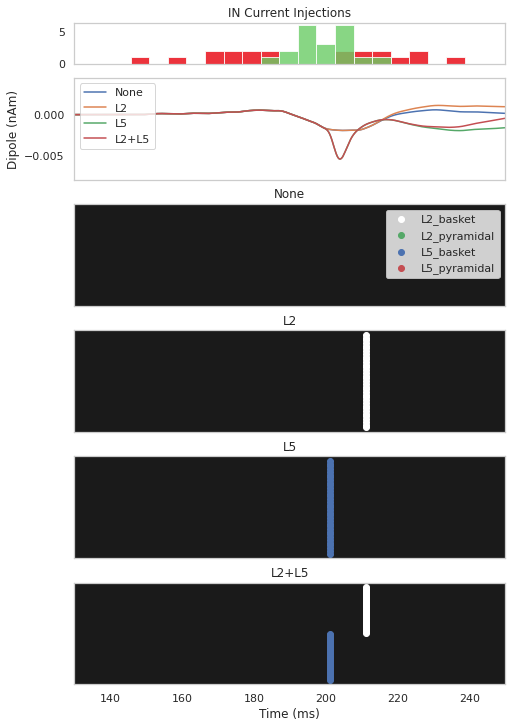

In [72]:
fig, axes = plt.subplots(6, 1, sharex=True, figsize=(7, 10), constrained_layout=True, 
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1, 1, 1]})
times = dpl_none[0].times

dpl_list = [dpl_none, dpl_l2, dpl_l5, dpl_l2_l5]
net_list = [net_none, net_l2, net_l5, net_l2_l5]
labels= ['None', 'L2', 'L5', 'L2+L5']

for idx, dpl in enumerate(dpl_list):
    dpl_smooth = dpl[0].copy().smooth(5).data['agg']
    axes[1].plot(times, dpl_smooth, label=labels[idx])
    net_list[idx].cell_response.plot_spikes_raster(ax=axes[idx+2], show=False)
    axes[idx+2].set_title(labels[idx])
    axes[idx+2].set_xlabel('')


p_mask = np.array(net_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)

axes[0].set_title('IN Current Injections')

axes[1].set_ylim([-0.008, 0.0045])
axes[2].set_xlabel('')
axes[5].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')
axes[1].legend(loc='upper left')
axes[3].get_legend().remove()
axes[4].get_legend().remove()
axes[5].get_legend().remove()


for ax in axes:
    ax.grid(False)

plt.xlim([130,250])
plt.savefig('u19_page2_figures/current_injection_spiking.png')


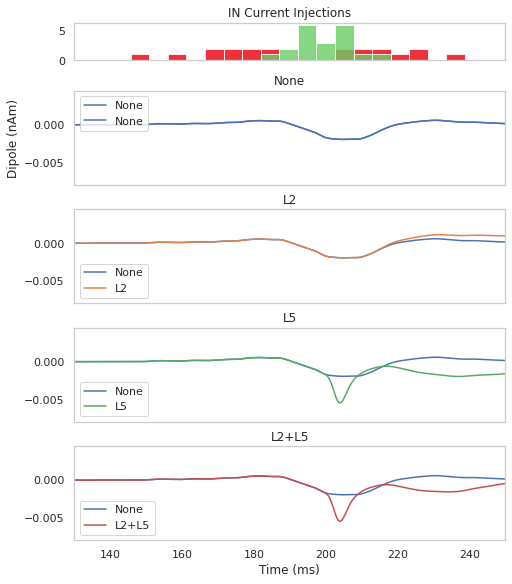

In [73]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(7, 8), constrained_layout=True, 
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1, 1]})
times = dpl_none[0].times

dpl_list = [dpl_none, dpl_l2, dpl_l5, dpl_l2_l5]
net_list = [net_none, net_l2, net_l5, net_l2_l5]
labels= ['None', 'L2', 'L5', 'L2+L5']

for idx, dpl in enumerate(dpl_list):
    dpl_smooth = dpl[0].copy().smooth(5).data['agg']
    dpl_none_smooth = dpl_list[0][0].copy().smooth(5).data['agg']

    axes[idx+1].plot(times, dpl_none_smooth, label='None')
    axes[idx+1].plot(times, dpl_smooth, label=labels[idx], color = f'C{idx}')
    axes[idx+1].set_title(labels[idx])
    axes[idx+1].legend()
    axes[idx+1].set_ylim([-0.008, 0.0045])


p_mask = np.array(net_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)

axes[0].set_title('IN Current Injections')

axes[2].set_xlabel('')
axes[4].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')
axes[1].legend(loc='upper left')


for ax in axes:
    ax.grid(False)

plt.xlim([130,250])
plt.savefig('u19_page2_figures/current_injection_none_compare.png')

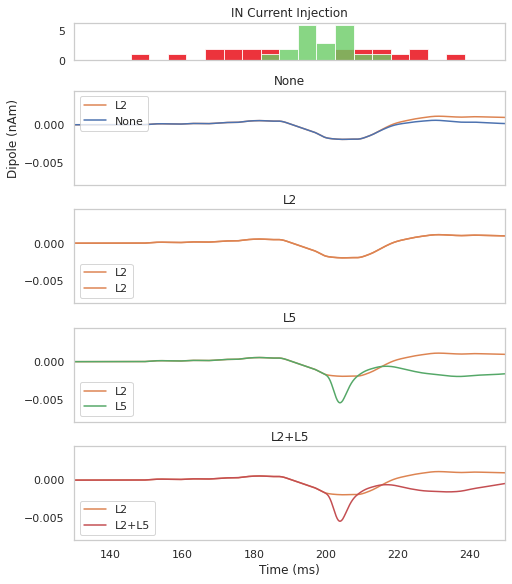

In [77]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(7, 8), constrained_layout=True, 
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1, 1]})
times = dpl_none[0].times

dpl_list = [dpl_none, dpl_l2, dpl_l5, dpl_l2_l5]
net_list = [net_none, net_l2, net_l5, net_l2_l5]
labels= ['None', 'L2', 'L5', 'L2+L5']

for idx, dpl in enumerate(dpl_list):
    dpl_smooth = dpl[0].copy().smooth(5).data['agg']
    dpl_l2_smooth = dpl_list[1][0].copy().smooth(5).data['agg']

    axes[idx+1].plot(times, dpl_l2_smooth, label='L2', color='C1')
    axes[idx+1].plot(times, dpl_smooth, label=labels[idx], color = f'C{idx}')
    axes[idx+1].set_title(labels[idx])
    axes[idx+1].legend()
    axes[idx+1].set_ylim([-0.008, 0.0045])


p_mask = np.array(net_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)

axes[0].set_title('IN Current Injection')

axes[2].set_xlabel('')
axes[4].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')
axes[1].legend(loc='upper left')



for ax in axes:
    ax.grid(False)

plt.xlim([130,250])
plt.savefig('u19_page2_figures/current_injection_l2_compare.png')


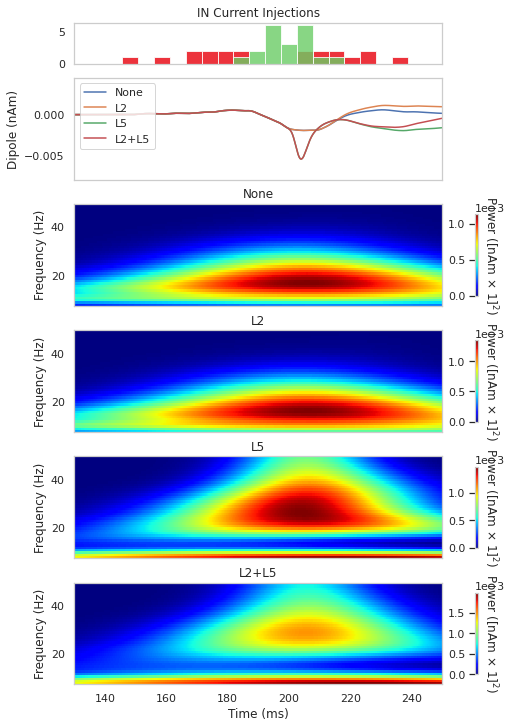

In [76]:
fig, axes = plt.subplots(6, 1, sharex=True, figsize=(7, 10), constrained_layout=True, 
                         gridspec_kw={'height_ratios': [0.4, 1 , 1, 1, 1, 1]})
times = dpl_none[0].times
freqs = np.arange(8, 50)

dpl_list = [dpl_none, dpl_l2, dpl_l5, dpl_l2_l5]
net_list = [net_none, net_l2, net_l5, net_l2_l5]
labels= ['None', 'L2', 'L5', 'L2+L5']

for idx, dpl in enumerate(dpl_list):
    dpl_smooth = dpl[0].copy().smooth(5).data['agg']
    axes[1].plot(times, dpl_smooth, label=labels[idx])
    dpl[0].copy().plot_tfr_morlet(freqs, ax=axes[idx+2], show=False, colormap='jet')

    axes[idx+2].set_title(labels[idx])
    axes[idx+2].set_xlabel('')


p_mask = np.array(net_list[0].cell_response.spike_types[0]) == 'Proximal Drive'
d_mask = np.array(net_list[0].cell_response.spike_types[0]) == 'Distal Drive'
p_times = np.array(net_list[0].cell_response.spike_times[0])[p_mask]
d_times = np.array(net_list[0].cell_response.spike_times[0])[d_mask]
bins = np.linspace(125, 275, 30)
axes[0].hist(p_times, color="#E8000B", label='Proximal', alpha=0.8, bins=bins)
axes[0].hist(d_times, color="#6ACC65", label='Distal', alpha=0.8, bins=bins)

axes[0].set_title('IN Current Injections')

axes[1].set_ylim([-0.008, 0.0045])
axes[2].set_xlabel('')
axes[5].set_xlabel('Time (ms)')
axes[1].set_ylabel('Dipole (nAm)')
axes[1].legend(loc='upper left')

for ax in axes:
    ax.grid(False)

plt.xlim([130,250])
plt.savefig('u19_page2_figures/current_injection_spectrogram.png')
